In [1]:
# Imports (model imports not included)
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [287]:
# All datasets
df = pd.read_csv('train.csv')
dft = pd.read_csv('test.csv')
datasets = [df, dft]

In [288]:
# Dataset
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [289]:
# Filling incoplete data
for d in datasets:
    d['Embarked'].fillna('S',inplace = True)
    d['Fare'].fillna(value = d.Fare.median(), inplace = True)

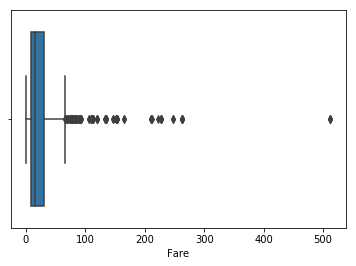

In [290]:
sn.boxplot(df['Fare'])

In [291]:
#Group fares
for d in datasets:
    groups = ['low','medium','high','very_high']
    cut_points = [-1, 50, 100, 200, 520]
    d['Fare_binned'] = pd.cut(d.Fare, cut_points, labels = groups)

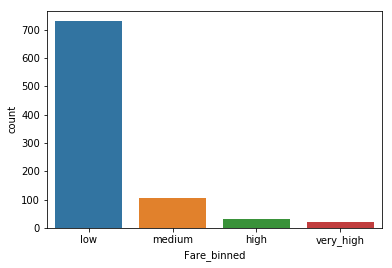

In [292]:
sn.countplot(df['Fare_binned'])

In [293]:
# Define a family size
for d in datasets:
    d['Family_size'] = d.SibSp + d.Parch + 1
    d.Family_size.replace(to_replace = [1], value = 'single', inplace = True)
    d.Family_size.replace(to_replace = [2,3], value = 'small', inplace = True)
    d.Family_size.replace(to_replace = [4,5], value = 'medium', inplace = True)
    d.Family_size.replace(to_replace = [6, 7, 8, 11], value = 'large', inplace = True)

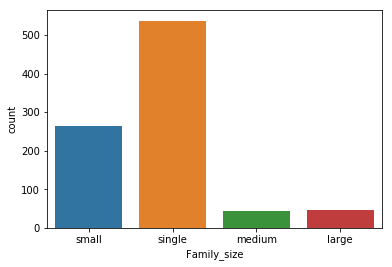

In [294]:
sn.countplot(df['Family_size'])

In [295]:
# Passengers titles from names
for d in datasets:
    d['Title'] = d.Name.str.extract('([A-Za-z]+)\.')
# Titles grouping
    d.Title.replace(to_replace = ['Dr', 'Rev', 'Col', 'Major', 'Capt'], value = 'Officer', inplace = True)
    d.Title.replace(to_replace = ['Dona', 'Jonkheer', 'Countess', 'Sir', 'Lady', 'Don'], value = 'Aristocrat', inplace = True)
    d.Title.replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'}, inplace = True)

C:\Users\Cone\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until


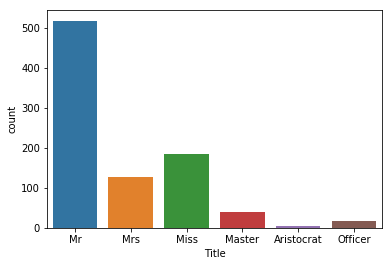

In [296]:
sn.countplot(df['Title'])

In [297]:
# Filling missing age values
for d in datasets:
    d.Age = d.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.median()))
# Grouping age
    label_names = ['infant','child','teenager','young_adult','adult','aged']
    cut_points = [0,6,12,18,40,60,81]
    d['Age_binned'] = pd.cut(d.Age, cut_points, labels = label_names)

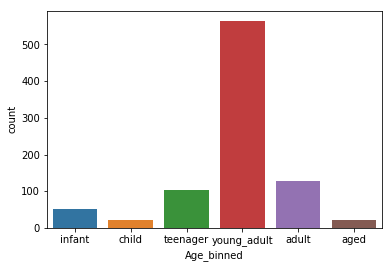

In [298]:
sn.countplot(df['Age_binned'])

In [299]:
# Dummies creation
z=pd.get_dummies(df.Embarked)
z.columns = ['CE', 'QE','SE']
#Gender dummies
b=pd.get_dummies(df.Sex)
# Age dummies
c=pd.get_dummies(df.Age_binned)
#Fare dummies
e=pd.get_dummies(df.Fare_binned)
# Title Dummies
f=pd.get_dummies(df.Title)
# Concat dataframe with all dummies    
data_for_merges = [df,z,b,c,e,f]
df2 = reduce(lambda  left,right: pd.concat([left,right], axis= 1), data_for_merges)

In [300]:
z=pd.get_dummies(dft.Embarked)
z.columns = ['CE', 'QE','SE']
b=pd.get_dummies(dft.Sex)
c=pd.get_dummies(dft.Age_binned)
e=pd.get_dummies(dft.Fare_binned)
f=pd.get_dummies(dft.Title)  
data_for_merges = [dft,z,b,c,e,f]
dft2 = reduce(lambda  left,right: pd.concat([left,right], axis= 1), data_for_merges)

In [301]:
#Features drop
datasets2 = [df2, dft2]
for d in datasets2:
    d.drop(columns= ['Embarked','Name','Cabin','Ticket','Sex','Age_binned','Fare_binned','Title','Family_size','SibSp'
                  ,'Parch', 'Age', 'Fare'], inplace= True)

In [319]:
cols = ['PassengerId','female','male','Survived','Pclass','CE','QE','SE','infant','child','teenager','young_adult','adult','aged','low',
        'medium','high','very_high','Aristocrat','Master','Miss','Mr','Mrs','Officer']
df2 = df2[cols] 

In [320]:
# Model Dataset 
df2.head()

,PassengerId,female,male,Survived,Pclass,CE,QE,SE,infant,child,...,low,medium,high,very_high,Aristocrat,Master,Miss,Mr,Mrs,Officer
0,1,0,1,0,3,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
1,2,1,0,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,3,1,0,1,3,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
3,4,1,0,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,5,0,1,0,3,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [341]:
#Model data and target
X = df2[df2.columns.drop(['Survived','PassengerId'])]
y = df2['Survived']

In [342]:
#Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

In [343]:
# Model NB
from sklearn.naive_bayes import MultinomialNB
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [344]:
#Acc Baseline

labels_predichas = modelo_NB.predict(X_test)
accuracy_score(y_test, labels_predichas)

0.8161434977578476

In [345]:
#Data normalization
from sklearn import preprocessing
X = preprocessing.scale(X, axis = 0)
X_test = preprocessing.scale(X_test, axis = 0)

In [347]:
#Logistic regresion (changes )
from sklearn.linear_model import LogisticRegression

scores = []
C = []
for i in np.linspace(0.0001,0.01,20): #accuracy decreses for higher values than 0.01. 
    reglogsklearn = LogisticRegression(fit_intercept=True,penalty='l2',C = i)
    reglogsklearn.fit(X_train, y_train)
    y_pred3 = reglogsklearn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred3))
    C.append(i)
tab = pd.DataFrame(data = [scores,C], index =['A','alpha'])
tab

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
A,0.811659,0.816143,0.816143,0.834081,0.829596,0.834081,0.834081,0.834081,0.834081,0.825112,0.825112,0.825112,0.825112,0.825112,0.825112,0.825112,0.825112,0.825112,0.825112,0.825112
alpha,0.000100,0.000621,0.001142,0.001663,0.002184,0.002705,0.003226,0.003747,0.004268,0.004789,0.005311,0.005832,0.006353,0.006874,0.007395,0.007916,0.008437,0.008958,0.009479,0.010000


In [348]:
#Random Forest

param_trees = {'n_estimators': [100, 300],
               'criterion': ['gini', 'entropy'],
               'max_features': [5, 10, 15, None],
               'max_depth': [4, 6, 8, 10, None], 
               'min_samples_leaf':[1, 2, 5, 10],
               'random_state': [0]}

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
kf = StratifiedKFold(n_splits=5, shuffle=True)

grid_search_rf = GridSearchCV(rf, param_grid=param_trees, cv=kf, verbose=1, n_jobs=3)
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   14.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   52.6s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  3.5min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  5.5min
[Parallel(n_jobs=3)]: Done 1600 out of 1600 | elapsed:  7.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 300], 'criterion': ['gini', 'entropy'], 'max_features': [5, 10, 15, None], 'max_depth': [4, 6, 8, 10, None], 'min_samples_leaf': [1, 2, 5, 10], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [349]:
grid_search_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

0.8161434977578476

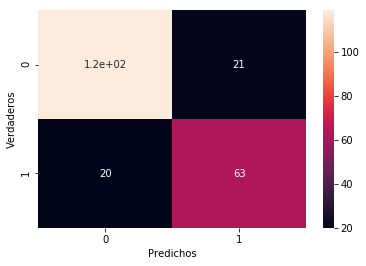

In [362]:
# Visualization on test data, and model scoring
rf = grid_search_rf.best_estimator_
rf.fit(X_train, y_train)
y_pred3 = rf.predict(X_test)
accuracy_score(y_test, y_pred3)
sn.heatmap(confusion_matrix(y_test, y_pred3), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');
accuracy_score(y_test, y_pred3)

True


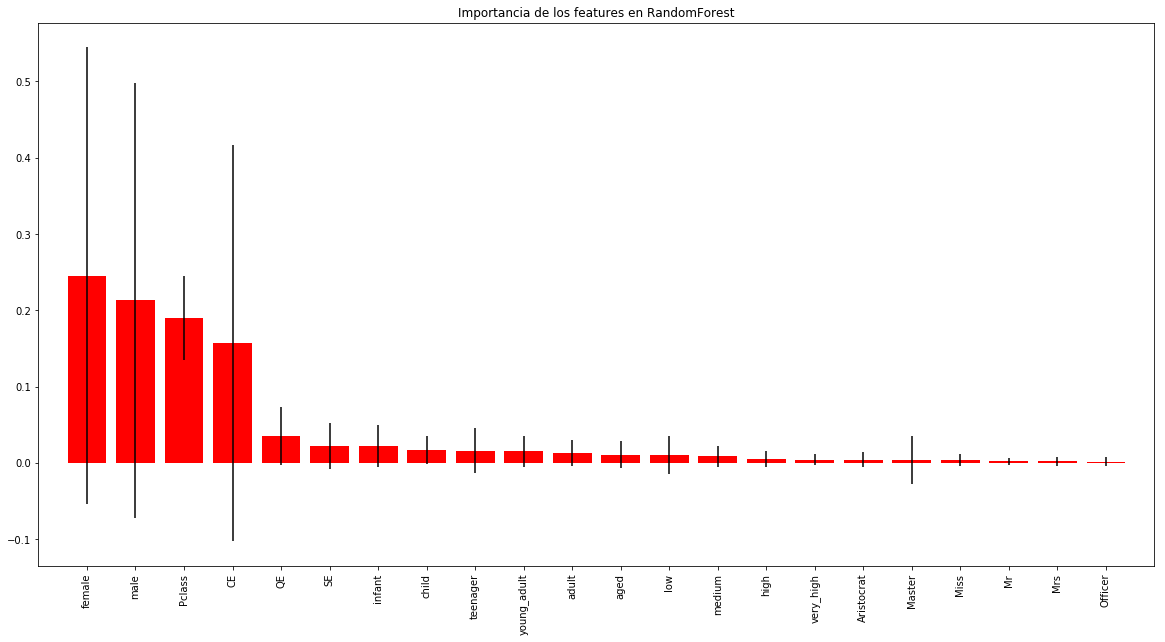

In [351]:
# Feature importance for rf
#Setting
importance = rf.feature_importances_
print (all(importance == np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)))
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
index = np.argsort(importance)[::-1]
nombres_features = df2[df2.columns.drop(['Survived','PassengerId'])]

#Plot
plt.figure(figsize= (20, 10))
plt.title("Importancia de los features en RandomForest")
plt.bar(range(df2[df2.columns.drop(['Survived','PassengerId'])].shape[1]), importance[index],
       color="r", yerr=std[index], align="center")
plt.xticks(range(df2[df2.columns.drop(['Survived','PassengerId'])].shape[1]), nombres_features[df2.columns.drop(['Survived','PassengerId'])], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [352]:
#GradientBoost
from sklearn.ensemble import GradientBoostingClassifier


gb = GradientBoostingClassifier()
param_grid_gb = {'max_depth': [5, 7, 10, 15, None],
                 'min_samples_leaf': [1, 5],
                 'learning_rate': [0.1, 0.5, 1.0],
                 'criterion': ['friedman_mse', 'mse', 'mae'],
                 'random_state': [0]}

grid = GridSearchCV(gb, param_grid =param_grid_gb,verbose = 1, n_jobs=3, cv = kf)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   13.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   46.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  4.7min
[Parallel(n_jobs=3)]: Done 450 out of 450 | elapsed:  4.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'max_depth': [5, 7, 10, 15, None], 'min_samples_leaf': [1, 5], 'learning_rate': [0.1, 0.5, 1.0], 'criterion': ['friedman_mse', 'mse', 'mae'], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [353]:
grid.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

0.7982062780269058

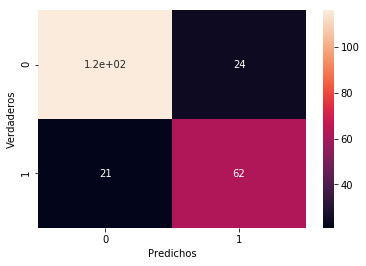

In [354]:
gbbest = grid.best_estimator_

gbbest.fit(X_train, y_train)
grid_pred = gbbest.predict(X_test)


accuracy_score(y_test, grid_pred)
sn.heatmap(confusion_matrix(y_test, grid_pred), annot=True)
plt.ylabel('Verdaderos')
plt.xlabel('Predichos');
accuracy_score(y_test, grid_pred)

In [355]:
# Selected model
# rf
#Full data
Xv = dft2[df2.columns.drop(['Survived','PassengerId'])]

In [356]:
#NB Model 0.765

In [ ]:
#rf Model 0.760

In [ ]:
# LogisticRegression 0.737

In [357]:
# Normalize all data
Xv = preprocessing.scale(Xv, axis = 0)

In [363]:
reglogsklearn = LogisticRegression(fit_intercept=True,penalty='l2',C = 0.003)
reglogsklearn.fit(X_train, y_train)
yreg = reglogsklearn.predict(Xv)

In [358]:
# Predict with rf model
rf = grid_search_rf.best_estimator_
yv = rf.predict(Xv)

In [364]:
# Predictions results
results = pd.DataFrame(dft['PassengerId'])
results2 = pd.DataFrame(yreg)
results = results.join(results2)
results.columns = ['PassengerId','Survived']
results.reset_index(drop=True, inplace = True)

In [365]:
# Export to csv
results.to_csv('sub_reg.csv',index = False)